# Problem Set 5, due June 2nd 11:59pm (end of day).

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download pset5.ipynb and the file "reviews.csv" from Canvas.

I suggest you to get familiar with 'groupby' and
_unique_ functions in 'numpy'.  You will probably also need
_CountVectorizer_ in 'sklearn.feature\_extraction.text' and
_MultinomialNB_ in 'sklearn.naive\_bayes'


In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os


# Introduction

In this assignment, you'll be analyzing movie reviews in an attempt to
determine whether movies are good or bad.  The file "reviews.csv",
contains reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh or Rotten.

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As before, we'll start out with some exploratory data analysis.

# 1 Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data, either missing review or missing fresh/rotten indicator.

In [6]:
#load reviews
reviews_data = pd.read_csv('reviews.csv.gz')

#load movies
movies_data = pd.read_table('movies.dat')

#before
print('Before removing NAs, the number of rows in reviews ', reviews_data.shape[0])
print('Before removing NAs, the number of rows in movies', movies_data.shape[0])

#drop nas 
reviews_data.dropna(inplace = 'True')
movies_data.dropna(inplace = 'True')

#after
print('After removing NAs, the number of rows in reviews', reviews_data.shape[0])
print('Before removing NAs, the number of rows in movies', movies_data.shape[0])

Before removing NAs, the number of rows in reviews  13442
Before removing NAs, the number of rows in movies 9423
After removing NAs, the number of rows in reviews 12737
Before removing NAs, the number of rows in movies 8975


## 1.1 Basic features of the dataset

Answer the following questions by having your code directly print the
answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [7]:
print('There are %d unique reviews ' %len(reviews_data.quote.unique()))

print('There are %d unique critics ' %len(reviews_data.critic.unique()))

print('There are %d unique movie titles in reviews dataset ' %len(reviews_data.title.unique()))

print('There are %d unique movie titles in movies dataset ' %len(movies_data.title.unique()))

print('There are %d unique publications in reviews dataset ' %len(reviews_data.publication.unique()))

There are 12167 unique reviews 
There are 540 unique critics 
There are 1715 unique movie titles in reviews dataset 
There are 8959 unique movie titles in movies dataset 
There are 64 unique publications in reviews dataset 


## 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

Does the distribution look normal?  Is it what you expect?

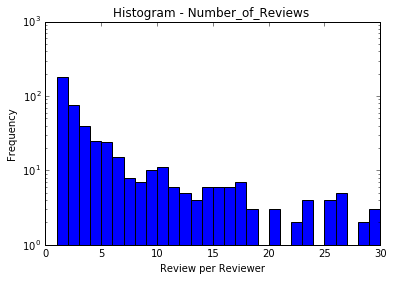

In [9]:
# enter your code here
r_byreviewers = reviews_data.groupby(['critic']).count()
plt.hist(r_byreviewers.quote, bins = 30, range=(0,30), log = True)
plt.title('Histogram - Number_of_Reviews ')
plt.xlabel('Review per Reviewer')
plt.ylabel('Frequency')

The distribution does not look normal. It observes a decreasing trend still presenting a logarthmic distribution.

## 1.3 Take a closer look of a few reviews

Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function*

In [10]:
# enter your code here
#convert to datetime
c_date = pd.to_datetime(reviews_data.review_date)
#copy datetime
reviews_data['conv_date'] = c_date

#select top 30
top30_reviewers = reviews_data.groupby(['critic']).count().sort_values(by='quote',ascending = False)[:30]

#get the values
top30_reviewers = (top30_reviewers.index.to_series()).get_values()
top30 = []

#for every reviewer, and the publication they worked for, find the first and last time
for i in top30_reviewers:
    #find publication
    publications = (reviews_data.ix[reviews_data.critic==i,'publication']).unique()
    
    for j in publications:
        
        #select the data with the reviewer and publication
        subset = reviews_data.ix[((reviews_data.critic==i) & (reviews_data.publication==j)),['conv_date']]
        
        #find minimum and maximum date
        min_date = subset.min()
        max_date = subset.max()
        
        #append it
        top30.append([i,j,str(min_date[0]),str(max_date[0])])
        
    

In [11]:
#convert to dataframe
pd.DataFrame(top30)

,0,1,2,3
0,Roger Ebert,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00
1,Roger Ebert,At the Movies,2000-01-01 00:00:00,2000-01-01 00:00:00
2,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
3,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
4,Variety Staff,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
5,Jonathan Rosenbaum,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
6,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
7,Dave Kehr,Chicago Reader,2000-01-01 00:00:00,2013-11-06 00:00:00
8,Dave Kehr,New York Daily News,2013-08-02 00:00:00,2013-10-22 00:00:00
9,Dave Kehr,Chicago Tribune,2013-02-20 00:00:00,2013-11-20 00:00:00


## 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [12]:
movies_data.columns

Index(['id', 'title', 'imdbID', 'spanishTitle', 'imdbPictureURL', 'year',
       'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews',
       'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore',
       'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh',
       'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating',
       'rtAudienceNumRatings', 'rtAudienceScore', 'rtPictureURL'],
      dtype='object')

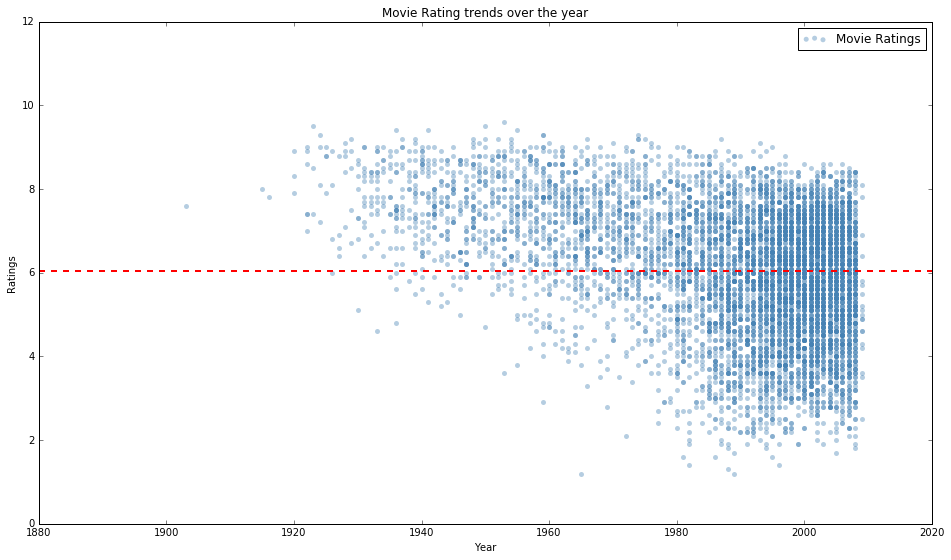

In [13]:
movies_data.rtAllCriticsRating = pd.to_numeric(movies_data.rtAllCriticsRating)

#filter out 0 ratings
ratingsByYear = movies_data.ix[~(pd.to_numeric(movies_data.rtAllCriticsRating) == 0),['year','rtAllCriticsRating']]

#create a scatter plot
plt.figure(figsize=(16,9))
plt.scatter(ratingsByYear.year,ratingsByYear.rtAllCriticsRating, alpha=0.4, s = 25, c = 'steelblue',lw=0,label='Movie Ratings')
plt.title("Movie Rating trends over the year")
plt.xlabel("Year")
plt.ylabel("Ratings")
plt.legend()
plt.axhline(ratingsByYear.rtAllCriticsRating.mean(), lw = 2, c ='red', ls = '--')

# Part 2: Naive Bayes

Now it gets fun!  You are going to use a Naive Bayes classifier to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

## 2.0 Using CountVectorizer

One thing that may help you in the following problems is the _CountVectorizer_ object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in the text.  (Note: the order of wordss is not preserved in the bag).   Here's a simple example, make sure you understand what's going on!

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = ["Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.", "When I joined them, as usual they said go away.", "Will not.", "This yard's as much mine as it is your, Jem Finch.", "I got just as much right to play in it as you have."]
# Harper Lee "To Kill a Mockingbrid"
print ("Original text:\n", '\n'.join(sentences))

vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(sentences)
# `fit` builds the vocabulary
x = vectorizer.transform(sentences).toarray()
# `transform` converts text to a bag of words
print ("Transformed text vector:\n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text:
 Next morning when I awakened I found Jem and Dill in the back yard deep in conversation.
When I joined them, as usual they said go away.
Will not.
This yard's as much mine as it is your, Jem Finch.
I got just as much right to play in it as you have.
Transformed text vector:
 [[1 0 1 0 1 1 1 1 0 1 0 0 0 2 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0
  0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0
  0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0]
 [0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
  1]
 [0 2 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1
  0]]
Words for each feature:
['and', 'as', 'awakened', 'away', 'back', 'conversation', 'deep', 'dill', 'finch', 'found', 'go', 'got', 'have', 'in', 'is', 'it', 'jem', 'joined', 'just', 'mine', 'morning', 'much', 'next', 'not', 'play', 'right', 'said', 'the', 'them', 'they', 'this', 'to', 'usual', 'when', '

## 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row is the bag-of-words representation for a single review.  This will be the *input* (fetaures) of your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* (target) from your model.
 
 Make sure to remove items with no review text

Feel free to use the _make\_xy_ function below to achieve it, but you can also create your own parser.

In [17]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(critics, vectorizer=None, min_df = None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [18]:
df = make_xy(reviews_data)
df[0].shape
df[1].shape

(12737,)

## 2.2 Test-Train split

Next, randomly split the data into two groups: a training (75%) set and a validation set (25%).  You can do this manually, as you have done earlier, but I recommend to use `train_test_split` in 'sklearn.model_selection'.

In [19]:
# enter your code here
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.25, random_state=42)

## 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the `MultinomialNB` from 'sklearn'.  Play with _MultinomialNB_ parameters.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [20]:
# enter your code here
import sklearn.naive_bayes as nb
#model 1
mod = nb.MultinomialNB()
mod.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_test,y_test)))

#model 2
mod = nb.MultinomialNB(alpha = 0.5)
mod.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_test,y_test)))

#model 3
mod = nb.MultinomialNB(alpha = 1)
mod.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_test,y_test)))

#model 4
mod = nb.MultinomialNB(alpha = 1.5)
mod.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_test,y_test)))

#model 5
mod = nb.MultinomialNB(alpha = 2.5)
mod.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_test,y_test)))


Model with TRAIN alpha 1.000, the score is 0.925879
Model with TEST alpha 1.000, the score is 0.781790
Model with TRAIN alpha 0.500, the score is 0.939489
Model with TEST alpha 0.500, the score is 0.775824
Model with TRAIN alpha 1.000, the score is 0.925879
Model with TEST alpha 1.000, the score is 0.781790
Model with TRAIN alpha 1.500, the score is 0.906302
Model with TEST alpha 1.500, the score is 0.771115
Model with TRAIN alpha 2.500, the score is 0.860657
Model with TEST alpha 2.500, the score is 0.751020


When we increase the smoothing parameter alpha, the accuracy keeps on decreasing. As we increase alpha, the sensitivity decreases and thus the accuracy decreases

## 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!

That was almost too easy, right?  Right.

Your next mission, if you feel you want to take an extra challenge, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:** Do this *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [42]:
# Your code here

# 3 Evaluation

## 3.1 Estimate the likelihood of your data

Calculate log-likelihood of a fitted model.  Log-likelihood is a way to assess the performance of your model.  Remeber -- likelihood is more-or-less the probability to observe your data (including your target).  Below is an example function that calculates the log-likelihood of an estimated model using `fitted_model.predict_logproba`.  You may use this function, or write your own.  

In [21]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 

The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews.

Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    # returns Nx2 array.  Columns are log(Pr(y == 0|x)), log(Pr(y==1|x))
    ll = prob[y == 0, 0].sum() + prob[y == 1, 1].sum()
    return ll



In [22]:
log_likelihood(mod,X_train,y_train)

-3206.6704750090216

## 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The `alpha` keyword in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

We are going to use cross-validation to tune these hyperparameters.  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.model_selection.cross_val_score`, that might save you a lot of time here...*

In [23]:
def make_xy(critics, vectorizer=None, min_df = None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df= min_df)
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [24]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for a in alphas:
    for m in min_dfs:
        X,y = make_xy(reviews_data, min_df = m)
        mod = nb.MultinomialNB(alpha=a)
        print('Alpha: ',a,' min_df: ', m, ' Score:' ,cross_val_score(mod,X,y,scoring=log_likelihood).mean())

Alpha:  0  min_df:  1e-05  Score: nan
Alpha:  0  min_df:  0.0001  Score: nan
Alpha:  0  min_df:  0.001  Score: nan
Alpha:  0  min_df:  0.01  Score: -2675.19976219
Alpha:  0  min_df:  0.1  Score: -2761.66084092
Alpha:  0.1  min_df:  1e-05  Score: -3731.59729135
Alpha:  0.1  min_df:  0.0001  Score: -3732.865271
Alpha:  0.1  min_df:  0.001  Score: -2686.83493688
Alpha:  0.1  min_df:  0.01  Score: -2674.90221367
Alpha:  0.1  min_df:  0.1  Score: -2761.6590239
Alpha:  1  min_df:  1e-05  Score: -2543.88208548
Alpha:  1  min_df:  0.0001  Score: -2499.88116213
Alpha:  1  min_df:  0.001  Score: -2492.04691484
Alpha:  1  min_df:  0.01  Score: -2672.37375012
Alpha:  1  min_df:  0.1  Score: -2761.64295348
Alpha:  5  min_df:  1e-05  Score: -4332.65361061
Alpha:  5  min_df:  0.0001  Score: -3104.80161883
Alpha:  5  min_df:  0.001  Score: -2358.82737144
Alpha:  5  min_df:  0.01  Score: -2663.80771059
Alpha:  5  min_df:  0.1  Score: -2761.57757237
Alpha:  10  min_df:  1e-05  Score: -5876.44009969
Alph

Choosing alpha as 5 and min_df as 0.001 because of the maximum likelihood

## 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [25]:
#Enter your code here
df = make_xy(reviews_data,min_df=0.001)
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.25)
mod = nb.MultinomialNB(alpha=5)
mod.fit(X_train,y_train)
print('Model with TRAIN alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_train,y_train)))
print('Model with TEST alpha %0.3f, the score is %0.6f'%(mod.alpha,mod.score(X_test,y_test)))

Model with TRAIN alpha 5.000, the score is 0.794179
Model with TEST alpha 5.000, the score is 0.741915


The accuracy of the model has decreased because we have cross-validated to find the best parameters to avoid over-fitting.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [26]:
# Enter your code here
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for a in alphas:
    for m in min_dfs:
        X,y = make_xy(reviews_data, min_df = m)
        mod = nb.MultinomialNB(alpha=a)
        print('Alpha: ',a,' min_df: ', m, ' Score:' ,cross_val_score(mod,X,y,scoring='accuracy').mean())


Alpha:  0  min_df:  1e-05  Score: 0.546204700662
Alpha:  0  min_df:  0.0001  Score: 0.596059701724
Alpha:  0  min_df:  0.001  Score: 0.733689445768
Alpha:  0  min_df:  0.01  Score: 0.660987490756
Alpha:  0  min_df:  0.1  Score: 0.624951098343
Alpha:  0.1  min_df:  1e-05  Score: 0.74114768587
Alpha:  0.1  min_df:  0.0001  Score: 0.739498908971
Alpha:  0.1  min_df:  0.001  Score: 0.735809439162
Alpha:  0.1  min_df:  0.01  Score: 0.660987472262
Alpha:  0.1  min_df:  0.1  Score: 0.624951098343
Alpha:  1  min_df:  1e-05  Score: 0.763131137442
Alpha:  1  min_df:  0.0001  Score: 0.761325497972
Alpha:  1  min_df:  0.001  Score: 0.737222496852
Alpha:  1  min_df:  0.01  Score: 0.661144519769
Alpha:  1  min_df:  0.1  Score: 0.625029603603
Alpha:  5  min_df:  1e-05  Score: 0.66750444447
Alpha:  5  min_df:  0.0001  Score: 0.708566209154
Alpha:  5  min_df:  0.001  Score: 0.733296937962
Alpha:  5  min_df:  0.01  Score: 0.660751827027
Alpha:  5  min_df:  0.1  Score: 0.624872556096
Alpha:  10  min_df: 

The model which is evaluated using accuracy is improved and now the alpha is 1 and min_df is  1e-5

## 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [28]:
def make_xy_withnames(critics, vectorizer=None, min_df = None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=min_df)
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y, vectorizer.get_feature_names()

In [32]:
# Enter your code here
df = make_xy_withnames(reviews_data,min_df=0.0001)

#split into test train
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.25)

#fit model
mod = nb.MultinomialNB(alpha=1)

f_names = df[2]
mod.fit(X_train,y_train)
I = np.identity(len(df[2]))
probs = mod.predict_proba(I)


In [33]:
probs = mod.predict_proba(I)
p = pd.DataFrame(probs, columns=['rotten','fresh'])
p.sort_values(['fresh'],axis = 0,ascending=False, inplace=True)
f_names = np.asarray(df[2])
positive_words = f_names[p.index[:10]]
negative_words = f_names[p.index[-10:]]
print('Positive Words: ', positive_words)
print('Negative Words: ', negative_words)

Positive Words:  ['delight' 'remarkable' 'intimate' 'captures' 'energetic' 'nevertheless'
 'vivid' 'absorbing' 'irresistible' 'gentle']
Negative Words:  ['muddled' 'tepid' 'obnoxious' 'disappointingly' 'unfunny' 'uninspired'
 'tiresome' 'pointless' 'lame' 'unfortunately']


### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [42]:
#Your code here
df = make_xy_withnames(reviews_data,min_df=0.0001)

#split into test train
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.25)

pro = mod.predict_proba(df[0])[:,0]
pred = mod.predict(df[0])
misclassified_rotten = np.argsort(pro[df[1] == 0])[:5]
misclassified_fresh = np.argsort(pro[df[1] == 1])[-5:]

In [43]:
fresh_review_quotes = []
rotten_review_quotes = []
for i in misclassified_rotten:
    rotten_review_quotes.append(reviews_data[df[1] == 0].quote.irow(i))
for j in misclassified_rotten:
    fresh_review_quotes.append(reviews_data[df[1] == 1].quote.irow(j))
    
#Stroring results in a dataframe
comb_df= pd.DataFrame({'Misclassified_fresh_review_quotes':fresh_review_quotes,
                   'Misclassified_rotten_review_quotes':rotten_review_quotes})

C:\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
C:\Miniconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]


In [44]:
comb_df

,Misclassified_fresh_review_quotes,Misclassified_rotten_review_quotes
0,"The dark, steel engraving look that cinematogr...",Walken is one of the few undeniably charismati...
1,"The twist at the end is a corker, but crucial ...","A bleak, annoyingly quirky Gen-X recasting of ..."
2,Thought-provoking and dramatically-solid.,"The performances are precise, the language is ..."
3,Hitchcock shows superb technical control and a...,"Despite its arresting visual style, its wave a..."
4,A riot of visual invention and weird humor tha...,Lauded as a witty moral fable with a revelator...


The assumption that each word is independent of the other is wrong because there can be associated words with negative and assertive as preceeding words. Such as not brilliant, not bad at all. Here, though the meaning is bad and good respectively, the predictions would be the opposite.

In [60]:
new_data = pd.Series(["This movie is not remarkable, touching, or superb in any way"])
vectorizer = CountVectorizer(min_df= 0.0001)
plusdata = reviews_data.quote.append(new_data)
X = vectorizer.fit_transform(plusdata)
X = X.tocsc()  # some versions of sklearn return COO format
new_data_pred = mod.predict_proba(X[-1:])

In [61]:
pd.DataFrame(new_data_pred,columns=['rotten','fresh'])

,rotten,fresh
0,0.00098,0.99902


The model predicted this as a fresh review, but the review represents otherwise.

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [393]:
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

In [515]:
#create a data frame
#save the data into easily accessible variable
data = pd.DataFrame(bdata.data)
target = pd.DataFrame(bdata.target)

#join data and target variable
data = pd.concat((data,target),axis=1)

#save the column names
cols = np.append(bdata.feature_names,'MEDV')

data.columns = cols

In [543]:
def compute_rmse(predictions,yvalues):
    #translate the formula above into python
    rmse = np.sqrt(((predictions-yvalues) ** 2).mean())
    
    #return the calculated value
    return rmse

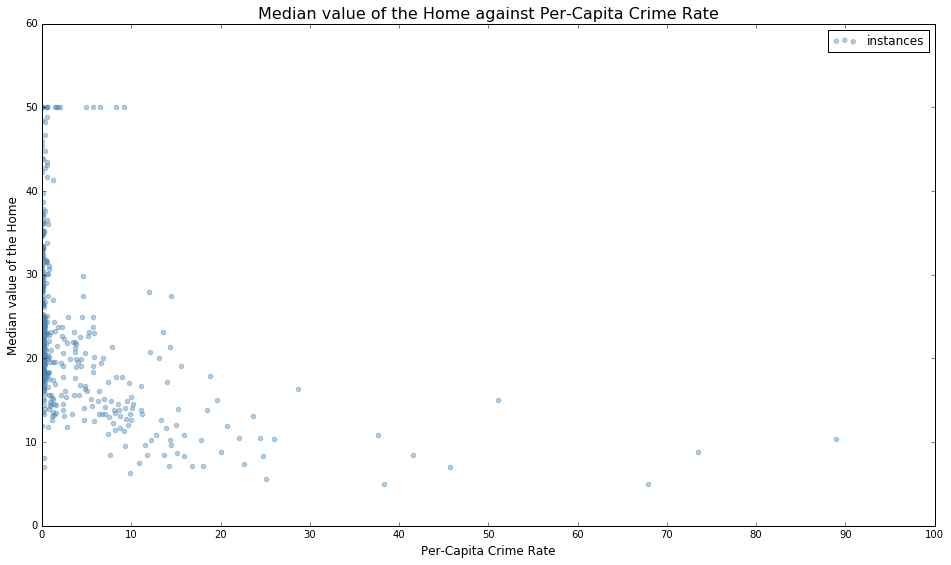

In [436]:
#set the plotsize
plt.figure(figsize=(16,9))

#set the limits of x-axis
plt.xlim(0,100)
plt.xticks(np.arange(min(data.CRIM), 101, 10))


#set the axis label
plt.xlabel('Per-Capita Crime Rate', fontsize= 12)
plt.ylabel('Median value of the Home',fontsize= 12)

#set the title
plt.title('Median value of the Home against Per-Capita Crime Rate', fontsize = 16)

#make the scatter plot
plt.scatter(data.CRIM,data.MEDV, alpha = 0.4, color = 'steelblue', marker='o', label = 'instances')

#show legend
plt.legend(loc = 'best')

In [551]:
dtrain,dtest = train_test_split(data,test_size=0.25)
import statsmodels.formula.api as smf
linRegm = smf.ols(formula = 'MEDV ~ RM',data=dtrain).fit()

#print the summary
linRegm.summary()

predictions = linRegm.predict(dtrain.RM)
print('The RMSE for train: ',compute_rmse(predictions,dtrain.MEDV))

The RMSE for train:  6.59044832669


In [550]:
linRegm = smf.ols(formula = 'MEDV ~ RM',data=dtest).fit()

#print the summary
linRegm.summary()

predictions = linRegm.predict(dtest.RM)
print('The RMSE for test: ',compute_rmse(predictions,dtest.MEDV))

The RMSE for test:  6.19240709697


### 4.2 So many scatterplots!

Choose 8 out of the of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026F1767A7B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000026F19CD7CF8>]], dtype=object)

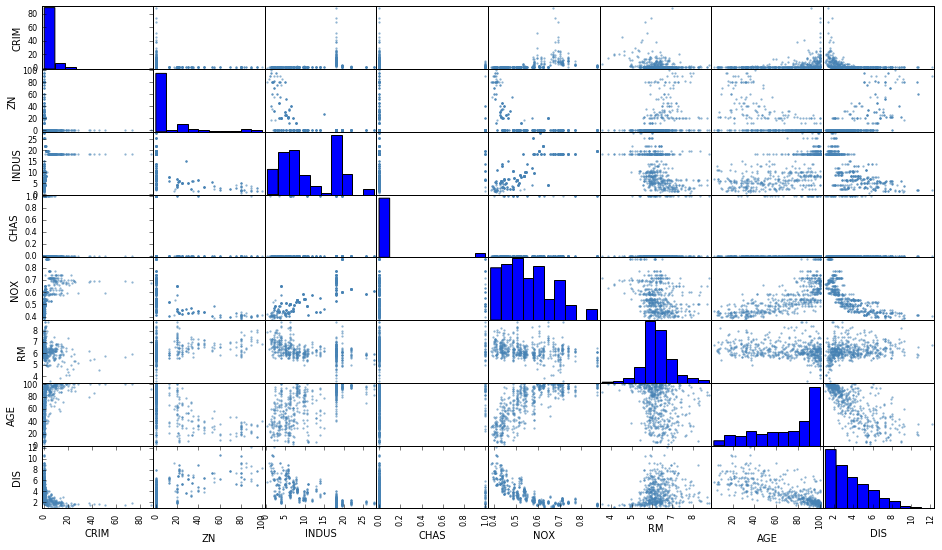

In [438]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(data[data.columns[:8]], figsize=(16,9), lw=0,c='steelblue',alpha=0.6)

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

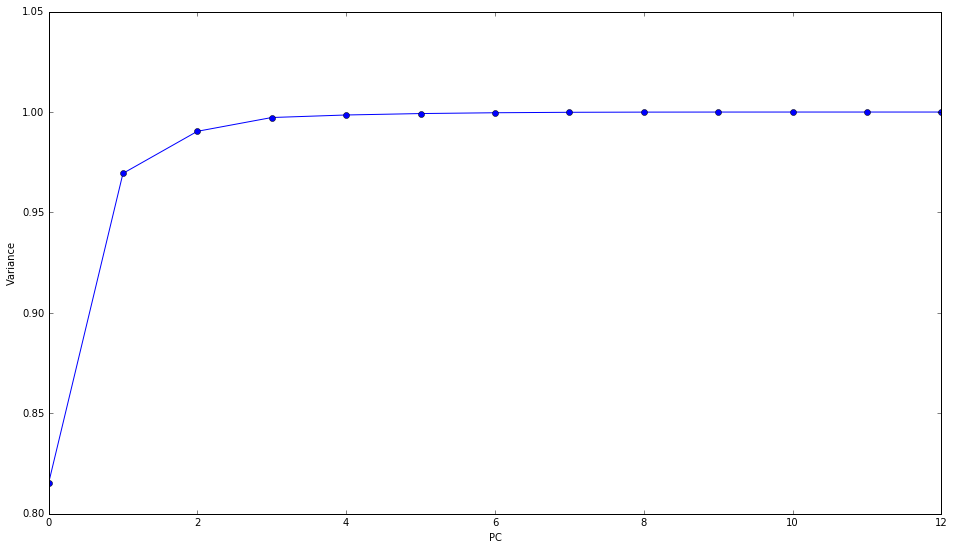

In [439]:
# Enter your code here
p = PCA(n_components=len(data.columns)-1)
dtrain,dtest = train_test_split(data,test_size = 0.34)
p.fit(dtrain[dtrain.columns[:13]])
plt.figure(figsize=(16,9))
plt.plot(np.cumsum(p.explained_variance_ratio_), '-o' )
plt.ylabel('Variance')
plt.xlabel('PC')

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

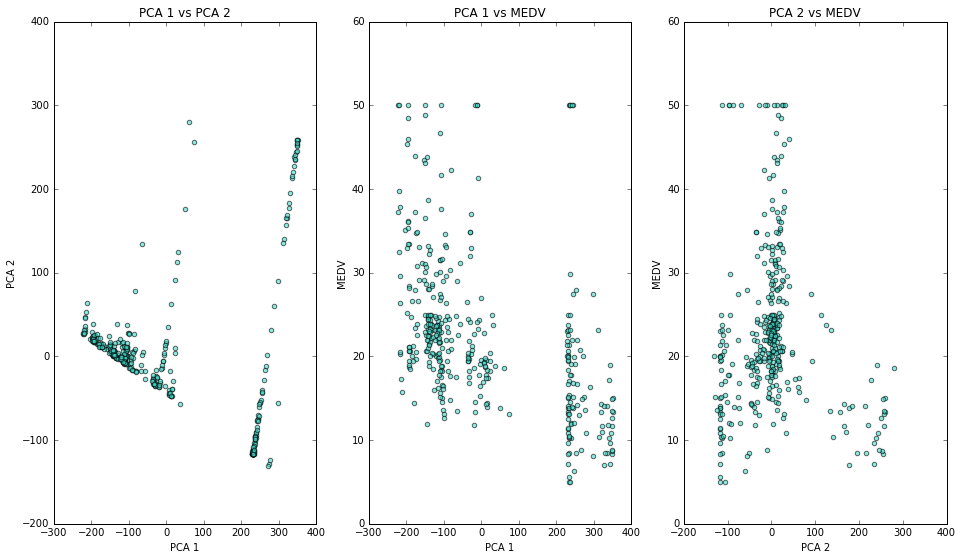

In [538]:
plt.figure(figsize=(16,9))
plt.grid()
plt.subplot(131)
p2 = PCA(2)
a = p2.fit_transform(dtrain[dtrain.columns[:13]])
p2= pd.DataFrame(a,columns=['1','2'])
plt.scatter(p2['1'],p2['2'], c='turquoise', alpha = 0.6)
plt.title('PCA 1 vs PCA 2')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(132)

plt.scatter(p2['1'],dtrain.MEDV,c='turquoise', alpha = 0.6)
plt.title('PCA 1 vs MEDV')
plt.xlabel('PCA 1')
plt.ylabel('MEDV')

plt.subplot(133)

plt.scatter(p2['2'],dtrain.MEDV,c='turquoise', alpha = 0.6)
plt.title('PCA 2 vs MEDV')
plt.xlabel('PCA 2')
plt.ylabel('MEDV')

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [557]:
df_pca = pd.concat([p2['1'],dtrain.MEDV],axis=1)

In [560]:
df_pca.head()
linRegm = smf.ols(formula = 'MEDV ~ 1',data=dtrain).fit()

#print the summary
linRegm.summary()

predictions = linRegm.predict(df_pca['1'])
print('The RMSE for train: ',compute_rmse(predictions,df_pca.MEDV))

The RMSE for train:  9.06222640857


In [561]:
p = PCA(2)
a = p.fit_transform(dtrain[dtest.columns[:13]])
p= pd.DataFrame(a,columns=['1','2'])
df_pca = pd.concat([p['1'],dtest.MEDV],axis=1)
df_pca.head()
linRegm = smf.ols(formula = 'MEDV ~ 1',data=dtest).fit()

#print the summary
linRegm.summary()

predictions = linRegm.predict(df_pca['1'])
print('The RMSE for test: ',compute_rmse(predictions,df_pca.MEDV))

The RMSE for test:  9.55350472543
